In [1]:
# imports
!pip install requests_cache --upgrade
!pip install PyPortfolioOpt --upgrade
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import requests_cache
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

In [2]:
# Pull stock data from yahoo finance
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')
session.headers = {     'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',     'Accept': 'application/json;charset=utf-8'     }

def get_data_for_multiple_stocks(tickers,start_date,end_date):
    #define helper function here
    #
    
    
    stocks = dict()
    stocks_adj_close = pd.DataFrame()
    # loop through all the tickers
    for ticker in tickers:
        
        # get the data for the specific ticker
        s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
      
        s.insert(0, "Ticker", ticker)  #insert ticker column so you can reference better later
        
        s['Prev Close'] = s['Adj Close'].shift(1)
        s['log_return'] = np.log(s['Adj Close']/s['Prev Close'])
        s['perc_return'] = (s['Adj Close']/s['Prev Close']) - 1
        # add it to the dictionary
        stocks[ticker] = s
        stocks_adj_close[ticker] = s['Adj Close']
    # return the dictionary
    return stocks, stocks_adj_close

We extended our end timepoint to end of september 2021

In [3]:
# Top 30 stocks in best portfolio
tickers = ['NVDA','QCOM', 'NXPI', 'MU', 'MRVL', 'AMD', 'MCHP', 'AVGO', 'XLNX', 'LRCX'
    ,'ON', 'INTC', 'TXN', 'ENPH', 'AMAT', 'CRUS', 'JBL', 'ADI', 'OLED', 'TSM'
    , 'IIVI', 'DIOD', 'AEIS', 'MTSI', 'TTMI', 'FLEX', 'MXL', 'SMTC', 'SYNA', 'AOSL']

#we only need the adjusted close data to work with this library
df =  get_data_for_multiple_stocks(tickers,start_date='2019-01-01',end_date= '2021-09-30')[1]
print(df)

                  NVDA        QCOM  ...        SYNA       AOSL
Date                                ...                       
2019-01-02   33.841225   53.195824  ...   37.540001  10.540000
2019-01-03   31.796638   51.620350  ...   35.020000   9.940000
2019-01-04   33.833775   52.454422  ...   36.009998  10.440000
2019-01-07   35.624950   52.306141  ...   36.259998  10.360000
2019-01-08   34.738064   51.852024  ...   37.970001  10.580000
...                ...         ...  ...         ...        ...
2021-09-24  220.809998  133.880005  ...  187.639999  31.629999
2021-09-27  216.600006  133.479996  ...  185.369995  33.610001
2021-09-28  206.990005  129.899994  ...  179.169998  32.480000
2021-09-29  205.169998  129.279999  ...  181.080002  31.219999
2021-09-30  207.160004  128.979996  ...  179.729996  31.370001

[693 rows x 30 columns]


In [4]:
#Checking if any NaN values in the data
nullin_df = pd.DataFrame(df,columns=tickers)
print(nullin_df.isnull().sum())

NVDA    0
QCOM    0
NXPI    0
MU      0
MRVL    0
AMD     0
MCHP    0
AVGO    0
XLNX    0
LRCX    0
ON      0
INTC    0
TXN     0
ENPH    0
AMAT    0
CRUS    0
JBL     0
ADI     0
OLED    0
TSM     0
IIVI    0
DIOD    0
AEIS    0
MTSI    0
TTMI    0
FLEX    0
MXL     0
SMTC    0
SYNA    0
AOSL    0
dtype: int64


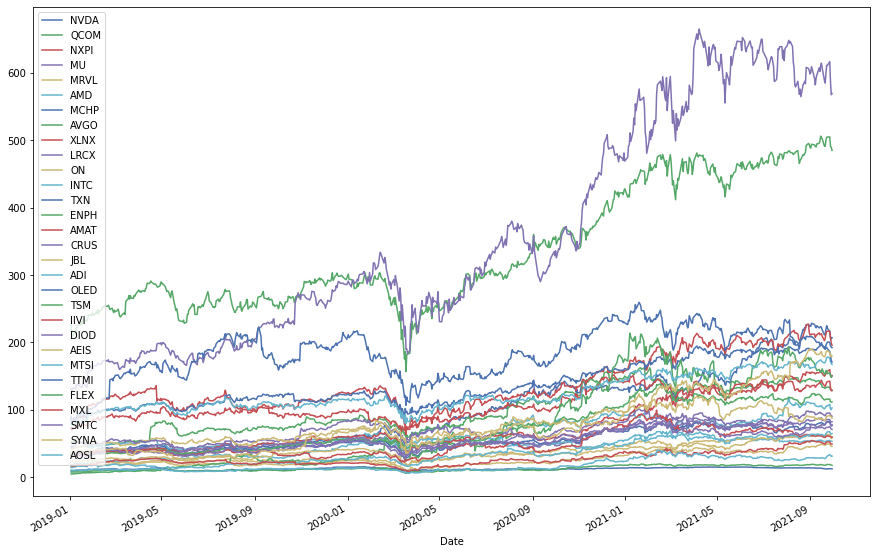

In [5]:
df.plot(figsize=(15,10));

Q6 part a) We now use forward looking expected returns in exponentially weighted return

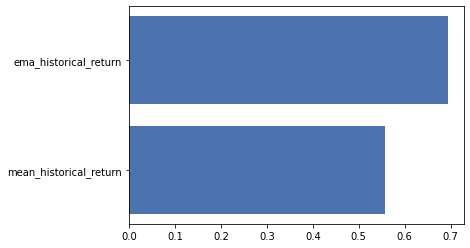

In [6]:
past_df, future_df = df.iloc[:-346], df.iloc[-346:]

future_rets = expected_returns.mean_historical_return(future_df)
mean_abs_errors = []
return_methods = [
    "mean_historical_return",
    "ema_historical_return",
    ]

for method in return_methods:
    mu = expected_returns.return_model(past_df, method=method)
    mean_abs_errors.append(np.sum(np.abs(mu - future_rets)) / len(mu))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, return_methods)
plt.show()

In [7]:
return_methods_arr = np.array(return_methods)
mean_abs_error_arr = np.array(mean_abs_errors)
return_error_df = pd.DataFrame({'return_methods':return_methods_arr, 'mean_abs_errors':mean_abs_error_arr})
return_error_df

,return_methods,mean_abs_errors
0,mean_historical_return,0.558088
1,ema_historical_return,0.693904


We observe that the ema_return is marginally better with a higher absolute deviation 

Covariance optimization

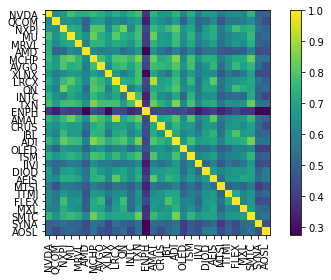

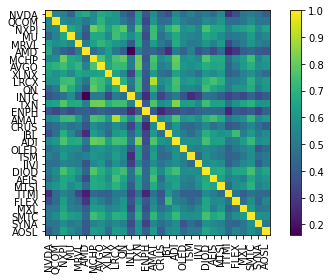

In [18]:
sample_cov = risk_models.sample_cov(past_df)
future_cov = risk_models.sample_cov(future_df)

plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

Just by visual inspection we can see that the covariance of past df may not capture some new features of the covariance in future df.

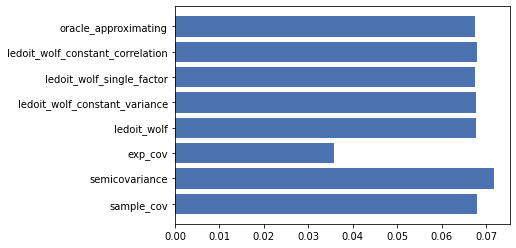

,risk_methods,mean_abs_errors
0,sample_cov,0.067858
1,semicovariance,0.071714
2,exp_cov,0.035884
3,ledoit_wolf,0.067621
4,ledoit_wolf_constant_variance,0.067621
5,ledoit_wolf_single_factor,0.067554
6,ledoit_wolf_constant_correlation,0.067858
7,oracle_approximating,0.067574


In [19]:
future_variance = np.diag(future_cov)
mean_abs_errors = []

risk_methods = [
    "sample_cov",
    "semicovariance",
    "exp_cov",
    "ledoit_wolf",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "ledoit_wolf_constant_correlation",
    "oracle_approximating",
]

for method in risk_methods:
    S = risk_models.risk_matrix(df, method=method)
    variance = np.diag(S)
    mean_abs_errors.append(np.sum(np.abs(variance - future_variance)) / len(variance))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, risk_methods)
plt.show()

risk_methods_arr = np.array(risk_methods)
mean_abs_error_arr = np.array(mean_abs_errors)
cov_error_df = pd.DataFrame({'risk_methods':risk_methods_arr, 'mean_abs_errors':mean_abs_error_arr})
cov_error_df

We observe that the exponential covariance matrix is a far better estimator of future variance vs the other models with a much lower mean absolute error.


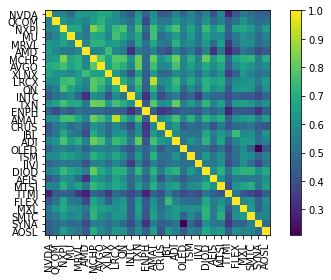

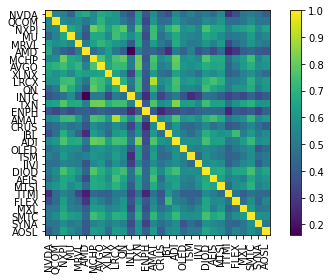

In [20]:
S = risk_models.risk_matrix(df, method='exp_cov')
plotting.plot_covariance(S, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

Now we compare the exponential covariance matrix (above) to the out of sample covariance matrix (below, same as before) and can observe that it seems to more accurately capture new features than before.

Q6 part d) New optimal portfolio with exp weighted returns and exponential covariance matrix 

In [22]:
mu_exp = expected_returns.return_model(df, method='ema_historical_return') #exponentially weighted
S = risk_models.risk_matrix(df, method='exp_cov') #exponential cov mat

In [23]:
ef = EfficientFrontier(mu_exp, S, weight_bounds=(0, 0.25)) #weight constraints must be <= 25%
ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamme is the tuning parameter, we determine that gamma = 0.3 is optimal
ef.efficient_return(0.8) #target return of 80%

weights = ef.clean_weights()
weights

OrderedDict([('NVDA', 0.16027),
             ('QCOM', 0.0),
             ('NXPI', 0.0),
             ('MU', 0.0),
             ('MRVL', 0.03828),
             ('AMD', 0.05228),
             ('MCHP', 0.0),
             ('AVGO', 0.04696),
             ('XLNX', 0.0),
             ('LRCX', 0.0),
             ('ON', 0.01556),
             ('INTC', 0.0097),
             ('TXN', 0.05684),
             ('ENPH', 0.11506),
             ('AMAT', 0.0),
             ('CRUS', 0.01334),
             ('JBL', 0.09533),
             ('ADI', 0.03417),
             ('OLED', 0.0),
             ('TSM', 0.03025),
             ('IIVI', 0.0),
             ('DIOD', 0.0),
             ('AEIS', 0.0),
             ('MTSI', 0.0),
             ('TTMI', 0.14021),
             ('FLEX', 0.0),
             ('MXL', 0.0),
             ('SMTC', 0.0),
             ('SYNA', 0.19175),
             ('AOSL', 0.0)])

In [24]:
ef.portfolio_performance(verbose=True);

Expected annual return: 80.0%
Annual volatility: 26.1%
Sharpe Ratio: 2.99


Using the exponentially weighted returns and exponential covariance matrix from 6.2, along with a new time period up to end September 2021, this new optimal portfolio is able to achieve the same expected annual returns as the previous optimal portfolio (from qn 3) but with lower volatility and higher Sharpe ratio.